 # Interpolation de la concentration de CO2 dans l'atmosphère à Mauna Loa

In [106]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import isoweek
import numpy as np
from scipy.optimize import curve_fit
import math

Les données de la concentration de CO2 dans l'atmosphère à l'observatoire de Mauna Loa, Hawaii, États-Unis sont disponibles sur le site Web de l'institut Scripps. Nous les récupérons sous forme d'un fichier en format CSV dont chaque ligne correspond à une semaine de la période demandée. Nous téléchargeons toujours le jeu de données complet, qui commence en 1958 et se termine avec un mois récent.

In [149]:
data_url = "https://scrippsco2.ucsd.edu/assets/data/atmospheric/stations/in_situ_co2/monthly/monthly_in_situ_co2_mlo.csv"
data_file = "monthly_in_situ_co2_mlo.csv"

import os
import urllib.request
if not os.path.exists(data_file):
    urllib.request.urlretrieve(data_url, data_file)
    
raw_data = pd.read_csv(data_file, skiprows=54,header=[0,2])
raw_data.columns=["Year" ,"Month" , "Date (Excel)" ,"Date(Numeric)" , "CO2 (raw)" ,"CO2 without seasons(raw)" , "CO2 (fitted)" , "CO2 without seasons(fitted)","CO2 (interpolated)", "CO2 without seasons(interpolated)"]
raw_data

Year  Month  Date (Excel)  Date(Numeric)  CO2 (raw)  \
0    1958      1         21200      1958.0411     -99.99   
1    1958      2         21231      1958.1260     -99.99   
2    1958      3         21259      1958.2027     315.70   
3    1958      4         21290      1958.2877     317.45   
4    1958      5         21320      1958.3699     317.51   
5    1958      6         21351      1958.4548     -99.99   
6    1958      7         21381      1958.5370     315.86   
7    1958      8         21412      1958.6219     314.93   
8    1958      9         21443      1958.7068     313.21   
9    1958     10         21473      1958.7890     -99.99   
10   1958     11         21504      1958.8740     313.33   
11   1958     12         21534      1958.9562     314.67   
12   1959      1         21565      1959.0411     315.58   
13   1959      2         21596      1959.1260     316.49   
14   1959      3         21624      1959.2027     316.65   
15   1959      4         21655      1959.2877     317.72   
16   1959      5         21685      1959.3699     318.29   
17   1959      6         21716      1959.4548     318.15   
18   1959      7         21746      1959.5370     316.54   
19   1959      8         21777      1959.6219     314.80   
20   1959      9         21808      1959.7068     313.84   
21   1959     10         21838      1959.7890     313.33   
22   1959     11         21869      1959.8740     314.81   
23   1959     12         21899      1959.9562     315.58   
24   1960      1         21930      1960.0410     316.43   
25   1960      2         21961      1960.1257     316.98   
26   1960      3         21990      1960.2049     317.58   
27   1960      4         22021      1960.2896     319.03   
28   1960      5         22051      1960.3716     320.04   
29   1960      6         22082      1960.4563     319.58   
..    ...    ...           ...            ...        ...   
738  2019      7         43661      2019.5370     411.78   
739  2019      8         43692      2019.6219     410.01   
740  2019      9         43723      2019.7068     408.48   
741  2019     10         43753      2019.7890     408.37   
742  2019     11         43784      2019.8740     410.22   
743  2019     12         43814      2019.9562     411.78   
744  2020      1         43845      2020.0410     413.38   
745  2020      2         43876      2020.1257     414.03   
746  2020      3         43905      2020.2049     414.44   
747  2020      4         43936      2020.2896     416.11   
748  2020      5         43966      2020.3716     417.10   
749  2020      6         43997      2020.4563     416.23   
750  2020      7         44027      2020.5383     414.47   
751  2020      8         44058      2020.6230     412.53   
752  2020      9         44089      2020.7077     411.19   
753  2020     10         44119      2020.7896     411.15   
754  2020     11         44150      2020.8743     412.88   
755  2020     12         44180      2020.9563     413.89   
756  2021      1         44211      2021.0411     415.17   
757  2021      2         44242      2021.1260     416.47   
758  2021      3         44270      2021.2027     417.14   
759  2021      4         44301      2021.2877     418.24   
760  2021      5         44331      2021.3699     418.92   
761  2021      6         44362      2021.4548     418.73   
762  2021      7         44392      2021.5370     -99.99   
763  2021      8         44423      2021.6219     -99.99   
764  2021      9         44454      2021.7068     -99.99   
765  2021     10         44484      2021.7890     -99.99   
766  2021     11         44515      2021.8740     -99.99   
767  2021     12         44545      2021.9562     -99.99   

     CO2 without seasons(raw)  CO2 (fitted)  CO2 without seasons(fitted)  \
0                      -99.99        -99.99                       -99.99   
1                      -99.99        -99.99                       -99.99   
2                      314.43        316.19             

Voici l'explication des colonnes données:

| Nom de colonne | Libellé de colonne                                                                                                                |
|----------------|-----------------------------------------------------------------------------------------------------------------------------------|
| Year           | Année
| Month          | Mois
| Date (Excel)   | Date au format Excel
| Date (Numeric) | Date au format decimal
| CO2 (raw)        | Concentration de CO2 en ppm brute
| CO2 without seasons(raw)	        | Concentration de CO2 en ppm en lissant les effets de saisons 
| CO2 (fitted)	        | Concentration de CO2 lissée par une fonction polynomiale de degré 3 associée à une fonction à 4 harmoniques
| CO2 without seasons(fitted)	     | Concentration de CO2 lissée par une fonction polynomiale de degré 3 uniquement |
| CO2 (interpolated)	      | Interpolation de la concentration de CO2 à l'aide de la somme des 2 fonctions décrites précédemment pour les points manquants |
| CO2 without seasons(interpolated)     | Interpolation de la concentration de CO2 à l'aide de la fonction polynomiale décrite précédemment pour les points manquants

Les premières lignes du fichier CSV sont un commentaire, que nous ignorons en précisant `skiprows=54`.

Les concentrations égales à -99.99 sont les concetrations non mesurées , nous les remplacont par NaN ( Not a Number) pour plus de clarté.

In [150]:
raw_data=raw_data.replace(-99.99,np.nan)


On trace ensuite l'évolution des concentrations mesurées en fonction du temps

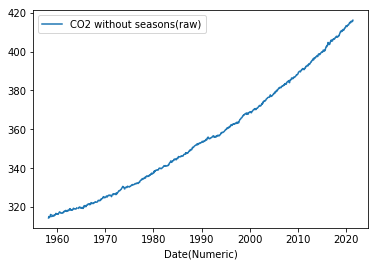

In [151]:
raw_data.plot(x='Date(Numeric)',y='CO2 without seasons(raw)')

On peut ensuite calculer les variations de ces concentrations pendant en un an en comparant à la valeur moyenne de l'année. On retrie ensuite ces valeurs pour plus de facilités pour les calculs suivants.

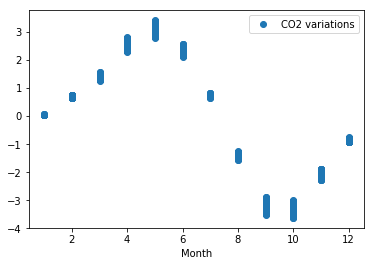

In [152]:
raw_data['CO2 variations'] = raw_data['CO2 (raw)']-raw_data['CO2 without seasons(raw)']
sorted_data = raw_data.sort_values('Month')
sorted_data.plot(x='Month',y='CO2 variations',style='o')

On peut ensuite interpoler la concentration pour calculer celle-ci en 2025. Pour cela on va interpoler les valeurs à l'aide d'un polynome de degré 3.  Il est néanmoins préférables de supprimer les valeurs NaN des calculs auparavant

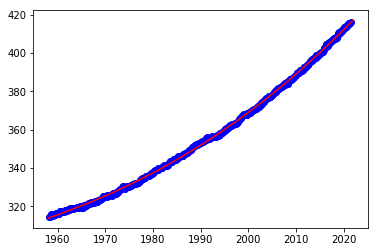

In [153]:
x=raw_data['Date(Numeric)']
y=raw_data['CO2 without seasons(raw)']
idx = np.isfinite(x) & np.isfinite(y)
coefficients=np.polyfit(x[idx], y[idx],deg=3)
xmod = np.linspace(min(x), max(x), 100)
modele = [coefficients[3] + coefficients[2] * val + coefficients[1] * val**2 + coefficients[0] * val**3  for val in xmod] 
plt.scatter(x, y, marker = "o", color = "blue", label = "Positions")
plt.plot(xmod, modele, color = "red")

On peut alors calculer la valeur en 2025 à l'aide de notre interpolation qui est de :

In [154]:
Prevision=coefficients[3] + coefficients[2] * 2025 + coefficients[1] * 2025**2 + coefficients[0] * 2025**3
Prevision

425.0003961302573

Pour réaliser l'interpolation des variations mensuelles , il nous faut définir la fonction initiale. Nous avons choisi d'utiliser une fonction sinusoidale à 3 harmoniques d'une période de 12 mois qui est la suivante

In [155]:
def func(x, a1, a2 , a3):
    return a1*np.sin((2*3.14/12)*x)+a2*np.sin((4*3.14/12)*x)+a3*np.sin((6*3.14/12)*x)

On vient alors de meme qu'auparavant identifier les coefficients de la fonction.

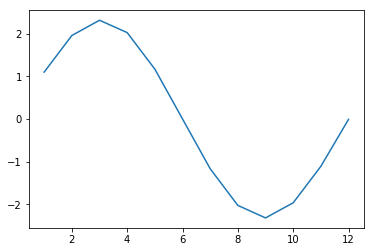

In [156]:
x=sorted_data['Month']
y=sorted_data['CO2 variations']
idx = np.isfinite(x) & np.isfinite(y)
popt,pcov = scipy.optimize.curve_fit(func, x[idx], y[idx])
plt.plot(x, popt[0]*np.sin((2*3.14/12)*x)+ popt[1]*np.sin((4*3.14/12)*x)+ popt[2]*np.sin((6*3.14/12)*x))